In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import umap

## UMAP

UMAP es la abreviación de Uniform Manifold Approximation and Projection


UMAP reduce la dimensionalidad de un conjunto de datos.
Convierte puntos cercanos (en el sentido Euclidiano) en altas dimensiones
en puntos cercanos en dos dimensiones.
Las ventajas más claras de UMAP sobre t-SNE son:

* UMAP refleja la **estructura global** de los puntos, t-SNE solamente la local.
* UMAP escala mejor que t-SNE para números grandes (millones) de instancias.
* UMAP es menos costosa en términos de RAM que t-SNE.

El mejor lugar para aprender sobre el algoritmo es la página de `umap-learn`, la biblioteca de python que vamos a usar en este notebook https://umap-learn.readthedocs.io/en/latest/basic_usage.html

Los objetivos de aprendizaje de este notebook son:
- Aprender a utilizar la implementación de UMAP de `umap-learn`
- Visualizar los resultados de UMAP.
- Aplicar k-means clustering sobre los resultados de UMAP.

## Dataset de entrenamiento

Vamos a utilizar el dataset `sklearn.datasets.load_digits()` que contiene
1797 digitos manuscritos representados en imágenes de 8 por 8 pixeles.
Es decir, cada elemento vive en 64 dimensiones. 
El objetivo al aplicar UMAP es ver si en efecto logran verse 10 clusters
que corresponderían a cada uno de los dígitos.

Empezamos por cargar los datos. 
Llamaremos `X` a las imágenes y `Y` a los enteros que marcan a qué dígito corresponde cada imagen.

In [3]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.reshape((n_imagenes, -1)) # para volver a tener los datos como imagen basta hacer data.reshape((n_imagenes, 8, 8))
Y = numeros['target']
print(np.shape(X), np.shape(Y))

(1797, 64) (1797,)


## Entrenamiento del algoritmo

Inicializamos el objeto TSNE.

Uno de los parámetros más relevantes es `n_neighbors`. Otros parámetros que tienen
una gran influencia son `min_dist` (la mínima distancia entre puntos en la representación de bajas dimensiones) y `metric` (métrica para medir distancias).


Más detalles: https://umap-learn.readthedocs.io/en/latest/parameters.html

In [4]:
reducer = umap.UMAP(n_neighbors=25)

Ahora ejecutamos la fase de aprendizaje

In [5]:
reducer.fit(X)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=25, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

## Visualización de los resultados

Extraemos la representación de los datos en el espacio bidimensional

In [8]:
embedding = reducer.transform(X)
np.shape(embedding)

(1797, 2)

Finalmente graficamos los datos en su nueva representación.
Para visualizar la relación de la nueva ubicación de los datos con su label original, utilizamos colores.

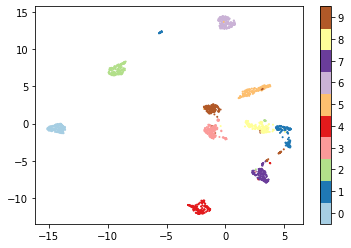

In [7]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y, cmap='Paired', s=1.0)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

Efectivamente, vemos que imágenes que corresponden a los mismos dígitos se encuentran ahora
en grupos vecinos. Además los grupos vecinos corresponden a dígitos similares y grupos
distantes corresponden a diferentes dígitos. 

Por ejemplo noten la gran diferencia entre 
el grupo de los dígitos que corresponden a 0 y los grupos que corresponden al 2.
En cambio el grupo que corresponde al 8 es bastante similar al grupo que corresponde a 1.

Con esto mente, vamos ahora a aplicar k-means clustering sobre los datos en su nueva representación.
Vamos a buscar 10 clusters.

## k-means clustering sobre los resultados

In [10]:
# clusters sobre los resultados de tsne
n_clusters = 10
k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
k_means.fit(embedding) # training
cluster = k_means.predict(embedding) # predice a cual cluster corresponde cada elmento
distance = k_means.transform(embedding) # calcula la distancia de cada elemento al centro de su cluster

Ahora graficamos los puntos coloreados por el cluster predicho por k-means clustering

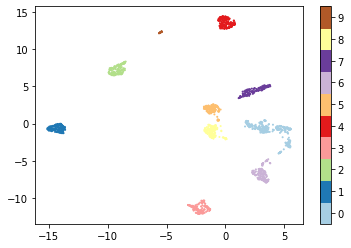

In [11]:
plt.scatter(embedding[:,0], embedding[:,1], c=cluster, cmap='Paired', s=1.0)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

## Visualización de imágnes en el mismo cluster

Para terminar vamos a graficar 10 ejemplos de imágenes para cada uno de los clusters

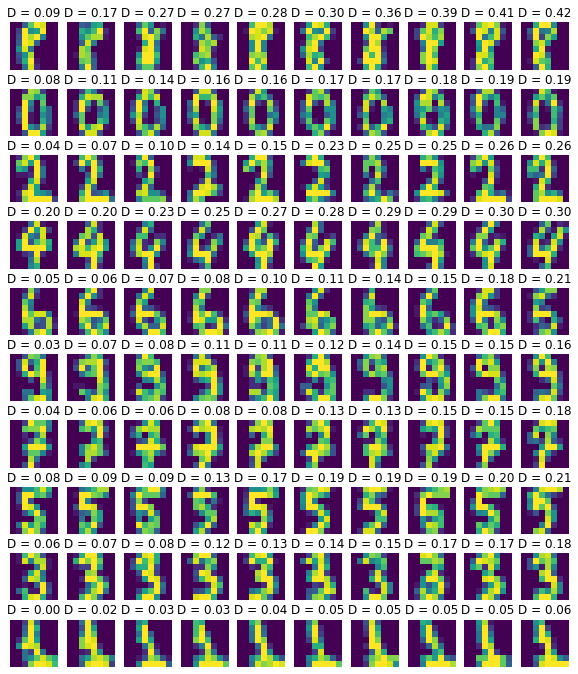

In [12]:
plt.figure(figsize=(10,12))
for i in range(n_clusters):
    ii = np.argsort(distance[:,i]) # es el orden de los objetos de menor a mayor a la distancia de su cluster
    n_seq = 10
    for l, ind in enumerate(ii[:n_seq]):
        plt.subplot(n_clusters,n_seq,i*n_seq +l +1)
        plt.imshow(imagenes[ind].reshape(8,8))
        plt.title("D = {:.2f}".format(distance[ind,i]))
        plt.axis('off')